In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [36]:
class Standoff:
    def __init__(self,num,power,md=0.1,dna=None):
        
        # номер игрока (от 0 до n_players-1)
        self.num = num
        
        # шанс уничтожить при попадании для каждого участника
        self.power = np.array(power)
        
        # шанс попасть в каждого участника для каждого участника (матрица) 
        #self.accuracy = np.array(accuracy)
        
        # количество участников
        self.n_players = len(power)
        
        # параметр дисперсии мутаций
        self.md = md
        
        # днк мага - матрица n_players*n_players
        if dna is None:
            self.dna = np.random.uniform(10,10,size=(self.n_players,self.n_players))
        else:
            self.dna = np.array(dna,dtype=np.float16)
            
        # оценка параметра приспособленности
        self.fitness = 0
    
    def mutate(self):
        #i,j = np.random.randint(self.n_players,size=2)
        mutated_dna = self.dna.copy()
        #mutated_dna[i,j] += np.random.normal(0,self.md)
        mutated_dna += np.random.normal(0,self.md,mutated_dna.shape)
        return Standoff(self.num,self.power,self.md,mutated_dna)
        
        
    def recombinate(self,other):
        i1, i2 = list(sorted(np.random.randint(self.n_players,size=2)))
        j1, j2 = list(sorted(np.random.randint(self.n_players,size=2)))
        mutated_dna = self.dna.copy()
        mutated_dna[i1:i2,j1:j2]=other.dna[i1:i2,j1:j2]
        return Standoff(self.num,self.power,self.md,mutated_dna)
    
    
    def make_move(self,state):
        
        # выбор цели
        target = np.argmax(self.dna@(np.array(state)*self.power))
        
        # результат хода
        #попадания по себе = пропуск хода
        if target == self.num:
            return state
        else:
            state[target] = 0 if np.random.random() < self.power[self.num] else 1
        return state

In [10]:
def npc_move(num,state,power):
    # выбор цели, npc ход не пропускают
    state[num] = 0
    a = np.arange(len(state))
    a = a[np.array(state) == 1]
    target = np.random.choice(a)

    # результат хода
    state[target] = 0 if np.random.random() < power[num] else 1
    state[num] = 1
    return state

In [11]:
def estimate_fitness(n_players,player):
    state = [1]*n_players
    #print(state)
    while sum(state) > 1:
        for i in range(n_players):
            if state[i] == 0: 
                continue
            if i == player.num:
                #print('player_move')
                state = player.make_move(state)
            else:
                state = npc_move(i,state,player.power)
            #print(state)
    return 1 if state.index(1) == player.num else 0

In [12]:
def genetic_standoff(n_players,num,power,iters,fit_size,pop_size,keep_size,spawn_size,mr=0.1,md=0.1,rr=0.01):
    # создаём начальную популяцию
    pop = np.array([Standoff(num,power,md) for i in range(pop_size)])
    
    history = []
    
    # цикл обучения
    for i in range(iters):
        
        # спавн случайных игроков
        spawn = [Standoff(num,power,md) for i in range(spawn_size)]
        pop = np.append(pop,spawn)
        
        # мутации и рекомбинации
        for j in range(pop_size+spawn_size):
            if np.random.random() < mr:
                new_pop = pop[j].mutate()
                pop = np.append(pop,new_pop) 
            if np.random.random() < rr:
                new_pop = pop[j].recombinate(pop[np.random.randint(pop_size+spawn_size)])
                pop = np.append(pop,new_pop)
        
        # оцениваем fitness
        fitness = np.array([0]*pop.size,dtype=np.float16)
        for j in range(pop.size):
            for k in range(fit_size):
                res = estimate_fitness(n_players,pop[j])
                fitness[j] += res
        fitness /= fit_size
        for j in range(pop.size):
            pop[j].fitness = fitness[j]
        
        # отбор по fitness
        pop = sorted(pop,key = lambda x: x.fitness, reverse=True)
        pop=pop[:keep_size]
        
        # размножение оставшихся
        norm_f = sum(p.fitness for p in pop)
        try:
            pop = np.append(pop,np.random.choice(a=pop,size=pop_size-keep_size,p=[pop[j].fitness/norm_f for j in range(keep_size)]))
        except:
            break
        
        history.append([fitness,pop])
    
    history = np.array(history,dtype='object')
    plt.plot([history[i,0][0] for i in range(iters)])
    return history

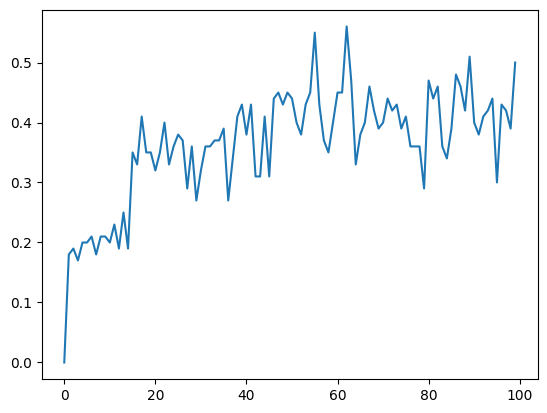

In [83]:
history1 = genetic_standoff(3,0,[0.8,0.8,0.8],100,100,5,5,0,mr=0.5,rr=0.1,md=1)

In [86]:
[history1[-1,1][i].make_move([1,0,1]) for i in range(5)]

[[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 1]]

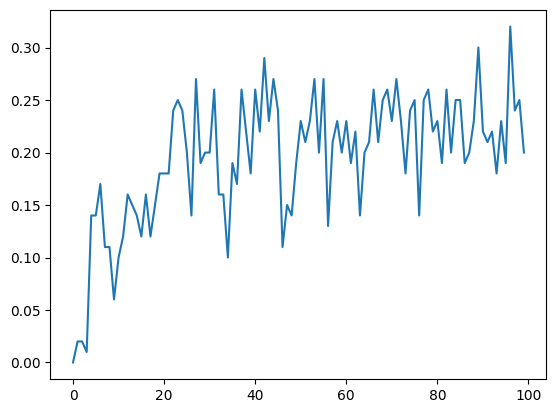

In [87]:
history4 = genetic_standoff(6,0,[0.8,0.8,0.2,0.2,0.2,0.2],100,100,10,10,0,mr=0.5,rr=0.1,md=0.1)

In [93]:
[history4[-1,1][i].make_move([1,0,0,0,1,0]) for i in range(5)]

[[1, 0, 0, 1, 1, 0],
 [1, 0, 0, 0, 1, 0],
 [1, 0, 0, 1, 1, 0],
 [1, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 1, 0]]